In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv 
import matplotlib.cm as cm

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Dropout, Flatten, InputLayer
from keras.optimizers import SGD

from keras.models import load_model
import h5py

from tensorflow import one_hot

import chess, chess.pgn, chess.svg, chess.polyglot
from IPython.display import SVG

import h5py


Using TensorFlow backend.


# Section 1: Load data

We load in data from a created H5 file that stores a board tensor and a label for each board

In [2]:
# Open h5 file and read x_train and y_train into
# The h5 file has two datasets: boards and labels
data = h5py.File('data/data.h5', 'r')

x_all = data.get('boards')
y_raw = data.get('labels')

In [3]:
# Transform data for regression
# Convert H5 datasets to numpy arrays
x_train_reg = np.asarray(x_all)
y_train_reg = np.asarray(y_raw)

for i in range(len(y_train_reg)):
    if abs(y_train_reg[i]) > 1:
        scalar = np.sqrt(abs(y_train_reg[i]))
        y_train_reg[i] = y_train_reg[i] / scalar

# # Scale to between -1 and 1
# y_train_reg /= 100

# Apply tanh function 
y_train_reg = np.tanh(2*y_train_reg/10)

# Transform data for classification

# x_train_class = np.asarray(x_all)
# y_train_class = 
# for i in range(len(y_all)):
#     if y_all[i] < -2:
#         y_all[i] = -1
#     elif y_all[i] > 2:
#         y_[i] = 1
#     else:
#         y_train[i] = 0
        
# y_train_class = np.eye(3)[y_train]

# print(y_train.shape)

<function matplotlib.pyplot.show(*args, **kw)>

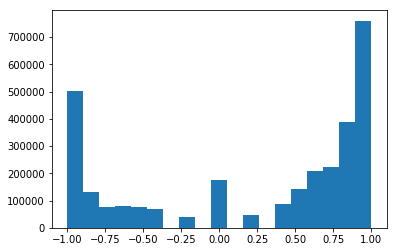

In [11]:
bins = np.linspace(-1, 1, 20)
plt.hist(y_train_reg, bins=bins)
plt.show

# Section 2: Define model

Here, I define my model. I used the Keras Sequential Model because ~~I'm lazy af~~

In [9]:
# Define MLP model
model = Sequential()

# Layer 1
model.add(Dense(2048, input_dim=768))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Layer 2
model.add(Dense(2048))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Layer 3
model.add(Dense(2048))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Layer 3
model.add(Dense(2048))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1))

# Compile model
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 2048)              1574912   
_________________________________________________________________
activation_5 (Activation)    (None, 2048)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
activation_6 (Activation)    (None, 2048)              0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 2048)              8192      
__________

In [12]:
model.fit(x_all, y_train_reg, batch_size=256, epochs=5, validation_split=0.2)

Train on 2400034 samples, validate on 600009 samples
Epoch 1/5
2400034/2400034 [==============================] - 4934s 2ms/step - loss: 0.4628 - mean_squared_error: 0.4628 - val_loss: 0.4033 - val_mean_squared_error: 0.4033
Epoch 2/5
 657408/2400034 [=======>......................] - ETA: 49:44 - loss: 0.3641 - mean_squared_error: 0.3641

KeyboardInterrupt: 

In [13]:
def encode(board):
    # Initialize matrix to hold encoded board
    # Each encoded board will be 8x8 with 12 channels at each square. 
    # Piece types are given as:
    # P - 1, N - 2, B - 3, R - 4, Q - 5, K - 6
    # White pieces occupy the first 6 indices, bladck pieces occupy the last 6 indices
    # [P, N, B, R, Q, K, p, n, b, r, q, k]
    encodedBoard = np.zeros((768,), dtype=np.int) 
    
    # Loop through each of the 64 positions on the board
    # Position 0 is where the Queen's rook initially starts
    for i in range(64):
        # Check if piece exists at specified square
        piece = board.piece_at(i)
        
        if piece is not None:
            # Get piece information
            piece_type = board.piece_at(i).piece_type
            piece_color = board.piece_at(i).color
            
            # Adj = 0 if white, 
            adj = 0
            if piece_color == False:
                adj = 6
            
            # If piece belongs to playing player, then 
            if piece_color == board.turn:
                encodedBoard[i*12+(adj + piece_type-1)] = 1
            else:
                encodedBoard[i*12+(adj + piece_type-1)] = -1
                
    return encodedBoard

Turn:  Black


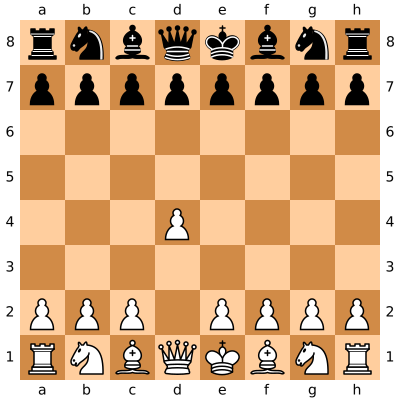

Board evaluation:  [[0.03711193]]


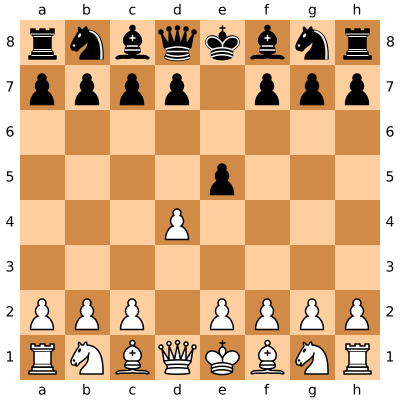

Board evaluation:  [[0.04774771]]


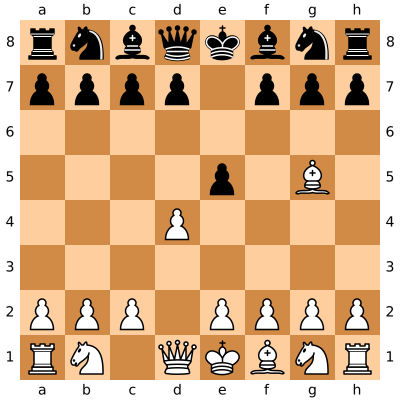

Board evaluation:  [[0.03908154]]


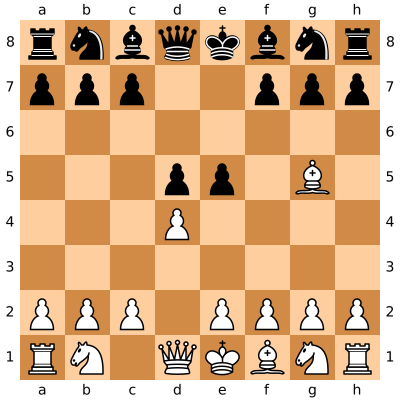

Board evaluation:  [[0.03585767]]


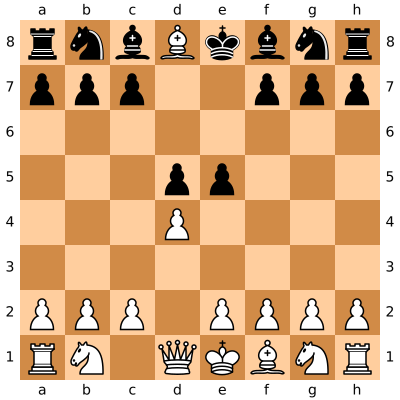

Board evaluation:  [[0.0363343]]


In [14]:
import chess
import chess.svg
import chess.polyglot

from IPython.display import SVG

board = chess.Board()

model = load_model('models/ChessAI_MLP.h5')

board.push_san("d4")
board_tensor = encode(board)
print("Turn: ", "Black")
board_eval = -model.predict(np.asarray([board_tensor]))
display(SVG(chess.svg.board(board=board,size=400)))
print("Board evaluation: ", board_eval)

board.push_san("e5")
board_tensor = encode(board)
board_eval = model.predict(np.asarray([board_tensor]))
display(SVG(chess.svg.board(board=board,size=400)))
print("Board evaluation: ", board_eval)

board.push_san("Bg5")
board_tensor = encode(board)
board_eval = -model.predict(np.asarray([board_tensor]))
display(SVG(chess.svg.board(board=board,size=400)))
print("Board evaluation: ", board_eval)

board.push_san("d5")
board_tensor = encode(board)
board_eval = model.predict(np.asarray([board_tensor]))
display(SVG(chess.svg.board(board=board,size=400)))
print("Board evaluation: ", board_eval)

board.push_san("Bd8")
board_tensor = encode(board)
board_eval = -model.predict(np.asarray([board_tensor]))
display(SVG(chess.svg.board(board=board,size=400)))
print("Board evaluation: ", board_eval)